## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [58]:
import os
import glob
import pandas as pd

In [37]:
#Absolute Path to frozen detection graph. This is the actual model that is used for the object detection.  
PATH_TO_CKPT = 'C:/Users/raika/Desktop/rai/shell_recognition/frozen_inference_graph.pb'

#Absolute path List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'C:/Users/raika/Desktop/rai/shell_recognition/morph_label_map.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR (./test).
PATH_TO_TEST_IMAGES_DIR = 'C:/Users/raika/Desktop/rai/shell_recognition/test'

assert os.path.isfile(PATH_TO_CKPT)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jp*g*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['C:/Users/raika/Desktop/rai/shell_recognition/test\\1487.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1488.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1489.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1490.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1491.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1492.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\1493.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\2.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\2077.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\33.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\35.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\4.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\452.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\454.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\455.jpg', 'C:/Users/raika/Desktop/rai/shell_recognition/test\\579.jpg', 'C:/U

In [38]:
len(TEST_IMAGE_PATHS)

20

In [19]:
%cd object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile

import tensorflow as tf

import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline

from object_detection.protos import anchor_generator_pb2

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

NUM_CLASSES = 10

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

[WinError 2] The system cannot find the file specified: 'object_detection'
C:\Users\raika\Desktop\rai\shell_recognition\object_detection


In [20]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    config = tf.ConfigProto()
    with graph.as_default():
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.1), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [21]:
from tqdm import tqdm
results = []
for image_path in tqdm(TEST_IMAGE_PATHS[0:]):
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    #plt.figure(figsize=IMAGE_SIZE)
    #plt.imshow(image_np)
    results.append(category_index[output_dict['detection_classes'][0]]["name"])
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.17s/it]


In [22]:
import numpy

In [39]:
import xml.etree.ElementTree as ET
PATH_TO_XML = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.xml"))
real = []
for file in PATH_TO_XML:
    tree = ET.parse(file)
    root = tree.getroot()
    real.append(root[6][0].text)

In [72]:
XML_FILES =  glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.xml"))
SNAIL_ID = [file.split('/')[-1] for file in XML_FILES]
pd.DataFrame(data = {'file': SNAIL_ID,'snail_class': real, 'predicted': results})

,file,snail_class,predicted
0,test\1487.xml,snail_P_B,snail_P_B
1,test\1488.xml,snail_P_O,snail_P_O
2,test\1489.xml,snail_Y_B,snail_Y_B
3,test\1490.xml,snail_Y_O,snail_Y_O
4,test\1491.xml,snail_Y_B,snail_Y_B
5,test\1492.xml,snail_Y_B,snail_Y_B
6,test\1493.xml,snail_Y_O,snail_Y_O
7,test\2.xml,snail_P_O,snail_P_O
8,test\2077.xml,snail_P_B,snail_P_B
9,test\33.xml,snail_P_B,snail_P_B


In [56]:
unique, count = numpy.unique(classes, return_counts=True)


In [57]:
len(XML_FILES)

20

In [43]:
import sklearn.metrics 
import pandas as pd
conf = sklearn.metrics.confusion_matrix(real[0:], results)
print(sklearn.metrics.classification_report(real[0:],results))

             precision    recall  f1-score   support

  snail_B_M       0.00      0.00      0.00         1
  snail_B_O       1.00      1.00      1.00         1
  snail_P_B       0.80      1.00      0.89         4
  snail_P_M       1.00      1.00      1.00         1
  snail_P_O       1.00      1.00      1.00         2
  snail_Y_B       1.00      1.00      1.00         6
  snail_Y_M       1.00      1.00      1.00         2
  snail_Y_O       1.00      1.00      1.00         3

avg / total       0.91      0.95      0.93        20



C:\Users\raika\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


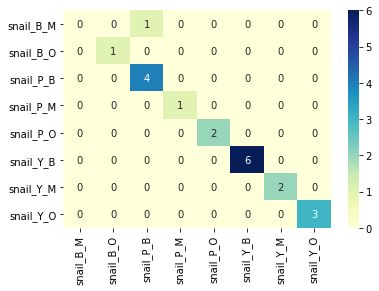

In [44]:
confusion= pd.DataFrame(conf, index = [i for i in ["snail_B_M", "snail_B_O", "snail_P_B","snail_P_M","snail_P_O","snail_Y_B","snail_Y_M","snail_Y_O"]],
                  columns = [i for i in ["snail_B_M", "snail_B_O", "snail_P_B","snail_P_M","snail_P_O","snail_Y_B","snail_Y_M","snail_Y_O"]])
import seaborn as sn
sn.heatmap(confusion, annot=True, cmap="YlGnBu")

In [45]:
import sklearn

### One Image result

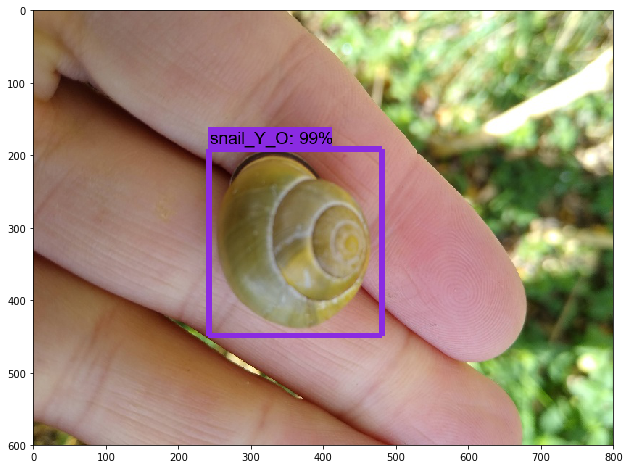

In [53]:
#Image path
image = Image.open('C:/Users/raika/Desktop/rai/shell_recognition/test/1493.jpg')
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)